### Imports

In [63]:
import numpy as np
import pandas as pd

from fingerprints.get_fp import output, input
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit import Chem

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib as mpl
import matplotlib.pyplot as plt
from plotnine import *

In [102]:
odorants = pd.read_csv('data/odorants.csv')
labels = pd.read_csv('data/labels.csv')
solubility = pd.read_csv('data/solubility.csv')

# Data prep

In [19]:
odorants.columns, labels.columns, solubility.columns

(Index(['CID', 'MolecularWeight', 'IsomericSMILES', 'IUPACName', 'name',
        'num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
        'num_of_O_atoms', 'num_of_N_atoms', 'PolarA', 'PolarB', 'TopoCharge',
        'VdW', 'AromaticA', 'AromaticB', 'HBondAcceptorCount',
        'HBondDonorCount', 'XLogP', 'TPSA'],
       dtype='object'),
 Index(['CID', 'IsomericSMILES', 'alcoholic', 'aldehydic', 'alliaceous',
        'almond', 'animal', 'anisic', 'apple', 'apricot',
        ...
        'tobacco', 'tomato', 'tropical', 'vanilla', 'vegetable', 'violet',
        'warm', 'waxy', 'winey', 'woody'],
       dtype='object', length=115),
 Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
        'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
        'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
        'measured log solubility in mols per litre', 'smiles'],
       dtype='object'))

In [20]:
# check if there are missing values
odorants.isna().any()


CID                   False
MolecularWeight       False
IsomericSMILES        False
IUPACName              True
name                  False
num_of_atoms          False
num_of_heavy_atoms    False
num_of_C_atoms        False
num_of_O_atoms        False
num_of_N_atoms        False
PolarA                False
PolarB                False
TopoCharge            False
VdW                   False
AromaticA             False
AromaticB             False
HBondAcceptorCount    False
HBondDonorCount       False
XLogP                 False
TPSA                  False
dtype: bool

Only the IUPACName is missing values, but that shouldn't be a big deal

In [21]:
# check the count of each label

label_count = pd.DataFrame(labels.iloc[:, 2:].sum())
label_count.columns = ['Count']
label_count


,Count
alcoholic,83
aldehydic,25
alliaceous,68
almond,50
animal,48
...,...
violet,26
warm,40
waxy,242
winey,174


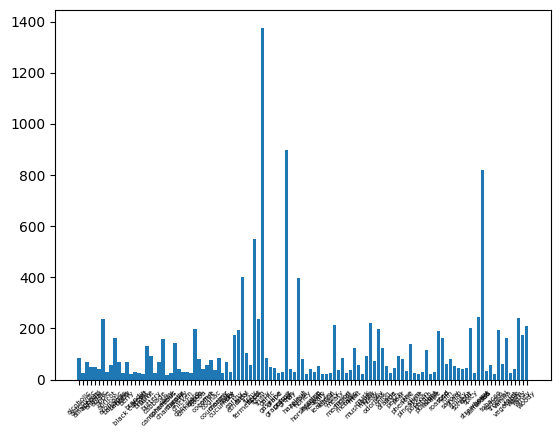

In [22]:
# barplot and rotate the x-axis labels
fig, ax = plt.subplots()
ax.bar(label_count.index, label_count["Count"]) 
plt.xticks(rotation=45, fontsize = 5)

plt.show()

In [23]:
# we see a class imbalance in the labeled data
# we cant see the x-axis labels clearly, so look at the head and tail of the ordered df to determine which labels have the highest and lowest counts
label_count.sort_values('Count', ascending = False)

,Count
fruity,1377
green,896
sweet,821
floral,551
fatty,403
...,...
leathery,20
horseradish,20
musk,20
radish,20


In [24]:
# results head tail label count
#               Count
# fruity        1377
# green         896
# sweet         821
# floral        551
# fatty         403

# leathery      20
# horseradish   20
# musk          20
# radish        20
# catty         17

In [25]:
# Now if we would look at the count of odor descriptions per CID (e.g. per compound)
compound_count = pd.DataFrame(labels.set_index('CID').iloc[:, 2:].sum(1))
compound_count.columns = ['Count']
# compound_count

In [26]:
# to big to plot, so we will look at the head and tail of the ordered df to determine which CIDs have the highest and lowest counts
compound_count.sort_values('Count', ascending = False)
# compound_count.sort_values('Count', ascending = False).head(10)
# compound_count.sort_values('Count', ascending = False).tail(10)


,Count
CID,
101363,9
95594,9
43263,9
605629,9
5463910,9
...,...
105516,1
90927,1
31260,0


In [27]:
# we see that the compounds with CID "31260", "121667", and "3776" have a count of zero and thus no odor descriptions
# we could remove these compounds from the dataset since we dont know if the odor of these sturctures is just not available or if it is something else.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 47'. Pick better value with 'binwidth'.


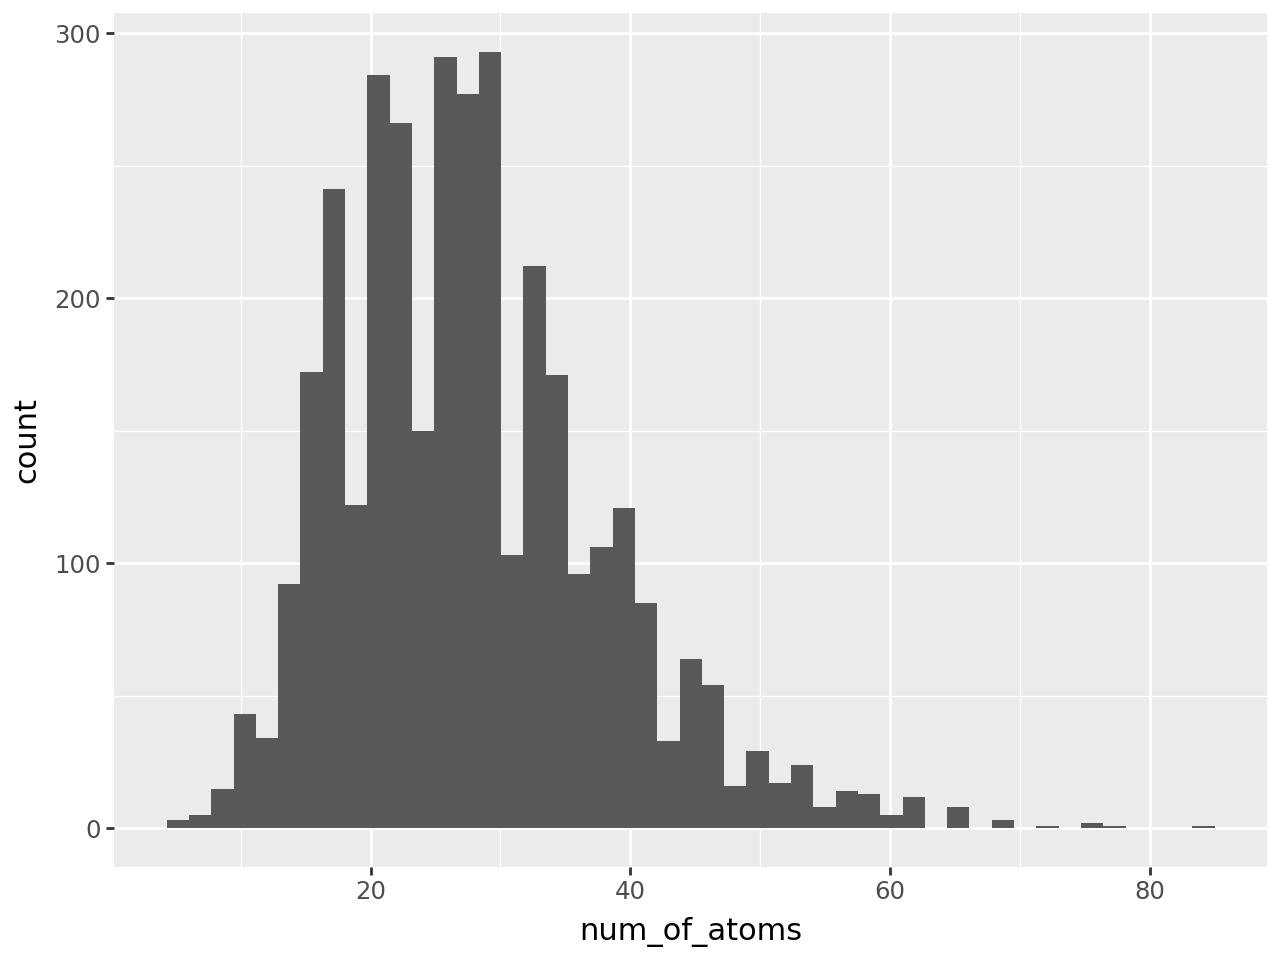

In [28]:
# what else would we want to represent a count from??
# example
ggplot(odorants, aes('num_of_atoms')) + \
    geom_histogram()

In [29]:
# check correlation between every numerical variable in odorants dataset (numerical cause name and smiles dont really contribute maybe? and cant get corr of num-categorical)
num_vars = odorants.select_dtypes(include = ['float64', 'int64'])
num_vars.loc[:, "MolecularWeight":].corr()


,MolecularWeight,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,PolarA,PolarB,TopoCharge,VdW,AromaticA,AromaticB,HBondAcceptorCount,HBondDonorCount,XLogP,TPSA
MolecularWeight,1.000000,0.913047,0.978150,0.923869,0.380665,-0.133188,0.951593,0.866679,-0.102324,0.959450,0.102252,0.101602,0.294155,0.294207,0.294049,0.294272
num_of_atoms,0.913047,1.000000,0.916925,0.935289,0.249481,-0.197838,0.988317,0.972421,-0.129744,0.983916,-0.153663,-0.153624,0.267893,0.270425,0.272957,0.270539
num_of_heavy_atoms,0.978150,0.916925,1.000000,0.966465,0.407493,-0.118332,0.946429,0.840868,-0.083249,0.956250,0.164689,0.164057,0.263148,0.263810,0.264555,0.263905
num_of_C_atoms,0.923869,0.935289,0.966465,1.000000,0.221457,-0.159466,0.959810,0.843742,-0.111864,0.952539,0.137907,0.137802,0.247649,0.252329,0.256950,0.252439
num_of_O_atoms,0.380665,0.249481,0.407493,0.221457,1.000000,-0.291541,0.213364,0.245602,0.144802,0.300273,-0.002377,-0.006213,0.057040,0.044769,0.033126,0.044657
num_of_N_atoms,-0.133188,-0.197838,-0.118332,-0.159466,-0.291541,1.000000,-0.172457,-0.203234,-0.018996,-0.203173,0.319394,0.323660,-0.062957,-0.067689,-0.070541,-0.067308
PolarA,0.951593,0.988317,0.946429,0.959810,0.213364,-0.172457,1.000000,0.948296,-0.138202,0.991670,-0.052387,-0.052316,0.283537,0.286761,0.289805,0.286865
PolarB,0.866679,0.972421,0.840868,0.843742,0.245602,-0.203234,0.948296,1.000000,-0.141570,0.943326,-0.278511,-0.278453,0.282392,0.286357,0.289052,0.286371
TopoCharge,-0.102324,-0.129744,-0.083249,-0.111864,0.144802,-0.018996,-0.138202,-0.141570,1.000000,-0.134384,-0.077875,-0.078161,-0.033601,-0.040153,-0.047782,-0.040151
VdW,0.959450,0.983916,0.956250,0.952539,0.300273,-0.203173,0.991670,0.943326,-0.134384,1.000000,-0.078551,-0.079217,0.303410,0.305838,0.307470,0.305903


In [77]:
# Sum the label columns to find the most common labels
label_sums = labels.iloc[:, -113:].sum().sort_values(ascending=False)
most_common_labels = label_sums.index[:1]  # Get the most common label
most_common_labels_list = most_common_labels.to_list()
most_common_labels_list.append('IsomericSMILES')
most_common_labels_list.append('CID')

# Filter data for molecules with these labels
# filtered_labels = labels[labels[most_common_labels].sum(axis=1) > 0]

# Filter data for column of most common labels
filtered_labels = labels[most_common_labels_list]



In [78]:
bitlength = 1024
nmolecules = len(filtered_labels)
fingerprints = np.zeros([nmolecules, bitlength]) #1024 values bits 0,1 - 1024-bit ECFP4 fingerprint
count = 0

for smiles in filtered_labels['IsomericSMILES']:
    mol = Chem.MolFromSmiles(smiles) # from SMILES to mol
    bits = np.array(AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)) #from mol we obtain the bit vector for each molecules
    fingerprints[count] = np.array(bits) #save each vector as an array
    count = count+1

target_labels = np.array(filtered_labels.drop(["IsomericSMILES", "CID"], axis=1))



In [79]:
print(fingerprints.shape)
print(target_labels.shape)

(3487, 1024)
(3487, 1)


In [106]:
x = fingerprints
y = target_labels.ravel()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [107]:
forest = RandomForestClassifier(random_state=42)
# multi_target_forest = MultiOutputClassifier(forest)

In [108]:
# Define a range of `n_estimators` to explore
param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 500]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(x_train, y_train)

# Best number of trees
print("Best number of trees:", grid_search.best_params_)

# Best score
print("Best cross-validated accuracy:", grid_search.best_score_)

# Using the best model
best_clf = grid_search.best_estimator_

# Make predictions
y_pred = best_clf.predict(x_test)

# Note: Adjust the scoring metrics as appropriate for your multi-label context
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Best number of trees: {'n_estimators': 500}
Best cross-validated accuracy: 0.7755455171393087
Accuracy: 0.7893982808022922
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       435
           1       0.74      0.68      0.71       263

    accuracy                           0.79       698
   macro avg       0.78      0.77      0.77       698
weighted avg       0.79      0.79      0.79       698

